In [1]:
from IPython.display import clear_output
!pip install tf_explain
! pip install segmentation-models
clear_output()
from tf_explain.core.grad_cam import GradCAM

In [2]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Average
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Flatten, Dense, Reshape, Multiply, Add,UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.6.4


In [3]:
import numpy as np 
import pandas as pd
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

**Load and Explore the Dataset**

In [ ]:
base_path = 'dataset2/Autistic Children Emotions - Dr. Fatma M. Talaat/Autistic Children Emotions - Dr. Fatma M. Talaat'
data_dir_list = ['Train', 'Test']

img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]
labels_list = []  

# Map folder names to emotion labels
emotion_to_label = {
    'surprise': 0,
    'fear': 1,
    'sad': 2,
    'sadness': 2,
    'neutral': 3,
    'natural': 3,
    'happy': 4,
    'joy': 4,
    'angry': 5,
    'anger': 5
}


for dataset in data_dir_list:  
    dataset_path = os.path.join(base_path, dataset)
    if not os.path.isdir(dataset_path):
        print(f'Warning: Directory {dataset_path} does not exist, skipping...')
        continue
        
    emotion_dirs = os.listdir(dataset_path)
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    
    for emotion in emotion_dirs:  
        emotion_path = os.path.join(dataset_path, emotion)
        
        if not os.path.isdir(emotion_path):
            continue
        
        emotion_lower = emotion.lower()
        if emotion_lower not in emotion_to_label:
            print(f'  Warning: Unknown emotion "{emotion}", skipping...')
            continue
        
        label = emotion_to_label[emotion_lower]
            
        img_list = [f for f in os.listdir(emotion_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        for img in img_list:
            img_path = os.path.join(emotion_path, img)
            
            if os.path.isdir(img_path):
                continue
            
            input_img = cv2.imread(img_path)
            
            if input_img is None:
                print(f'  Warning: Could not read image {img_path}')
                continue
            
            input_img_resize = cv2.resize(input_img, (48, 48))
            img_data_list.append(input_img_resize)
            labels_list.append(label)  
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-Train

Loaded the images of dataset-Test



(833, 48, 48, 3)

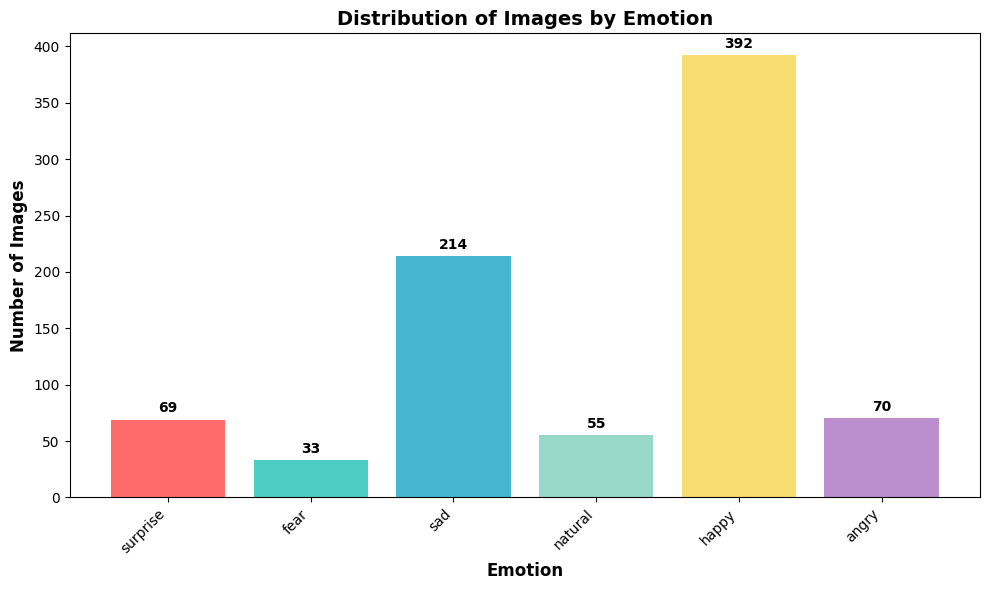


Total images: 833

Label distribution:
  surprise: 69 images (8.28%)
  fear: 33 images (3.96%)
  sad: 214 images (25.69%)
  natural: 55 images (6.60%)
  happy: 392 images (47.06%)
  angry: 70 images (8.40%)


In [17]:

import matplotlib.pyplot as plt
import numpy as np


labels_array = np.array(labels_list)
emotion_names = ['surprise', 'fear', 'sad', 'natural', 'happy', 'angry']
# Actual label values in dataset: 0, 1, 2, 4, 5, 6 (no label 3 since disgust was removed)
label_values = [0, 1, 2, 4, 5, 6]
label_counts = [np.sum(labels_array == i) for i in label_values]


plt.figure(figsize=(10, 6))
bars = plt.bar(emotion_names, label_counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#98D8C8', '#F7DC6F', '#BB8FCE'])
plt.xlabel('Emotion', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Distribution of Images by Emotion', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')


for i, (bar, count) in enumerate(zip(bars, label_counts)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(label_counts)*0.01, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f'\nTotal images: {len(labels_array)}')
print('\nLabel distribution:')
for name, count in zip(emotion_names, label_counts):
    print(f'  {name}: {count} images ({count/len(labels_array)*100:.2f}%)')

In [25]:
num_classes = 6

labels = np.array(labels_list, dtype='int64')
num_of_samples = img_data.shape[0]


names = ['surprise','fear','sadness','natural','happy','anger']

def getLabel(id):
    return ['surprise','fear','sadness','natural','happy','anger'][id]

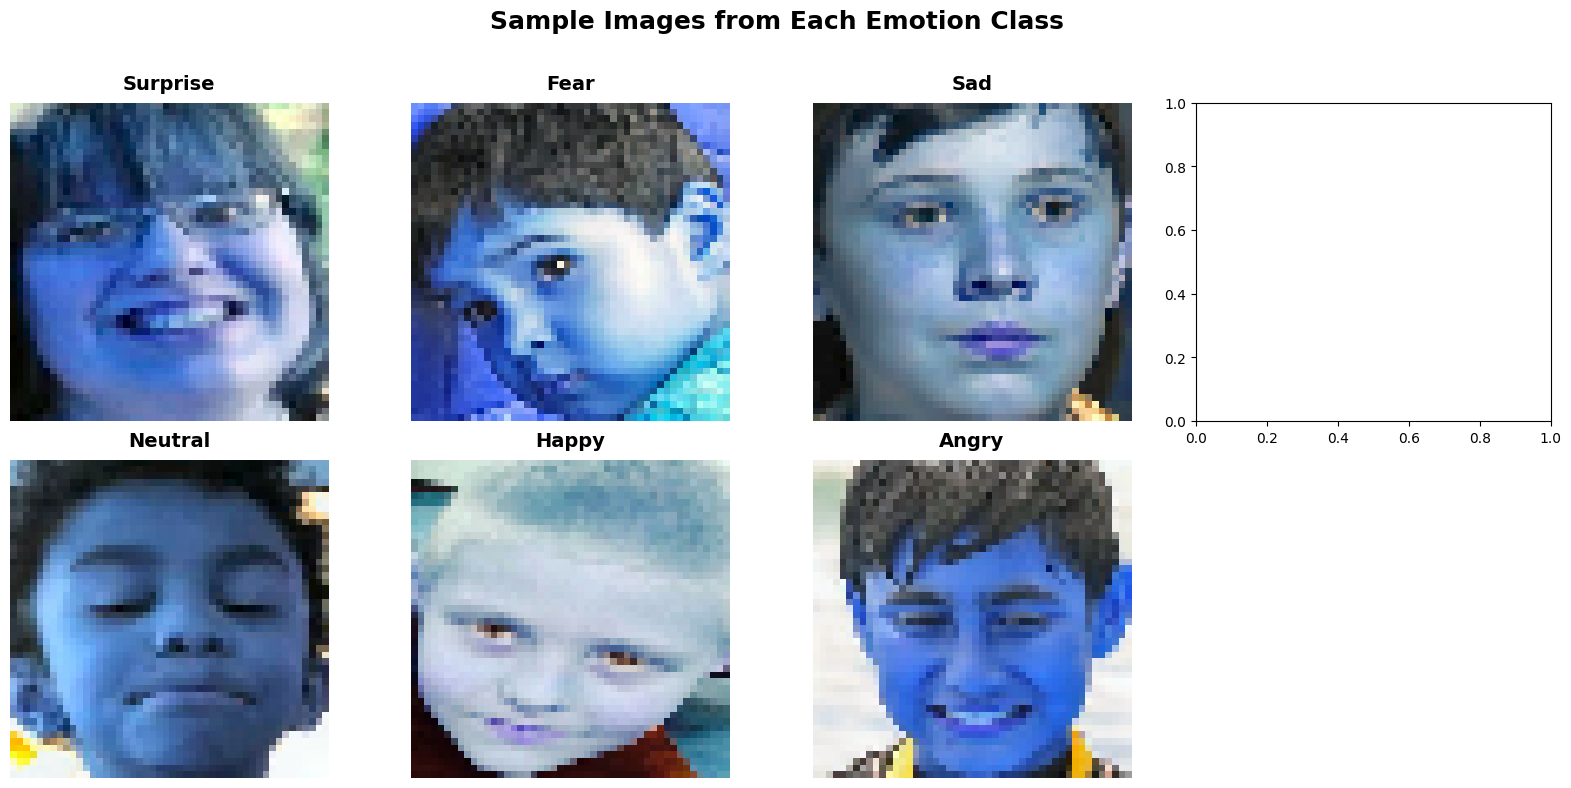


Random Sample Images Summary:
Surprise    : Image index    91 (Total:    69 images)
Fear        : Image index    75 (Total:    33 images)
Sad         : Image index   180 (Total:   214 images)
Neutral     : Image index    20 (Total:    55 images)
Happy       : Image index   457 (Total:   392 images)
Angry       : Image index   788 (Total:    70 images)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

emotion_names = ['Surprise', 'Fear', 'Sad', 'Neutral', 'Happy', 'Angry']
emotion_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#BB8FCE']

labels_array = np.array(labels_list)

sample_indices = []
for label_id in range(7):
    indices = np.where(labels_array == label_id)[0]
    if len(indices) > 0:
        random_idx = random.choice(indices)
        sample_indices.append(random_idx)
    else:
        sample_indices.append(None)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Images from Each Emotion Class', fontsize=18, fontweight='bold', y=0.98)

axes = axes.flatten()

for i, (label_id, emotion_name, color) in enumerate(zip(range(7), emotion_names, emotion_colors)):
    if sample_indices[label_id] is not None:
        idx = sample_indices[label_id]
        img = img_data[idx]
        
        axes[i].imshow(img, cmap='gray' if img.shape[2] == 1 else None)
        axes[i].set_title(emotion_name, fontsize=14, fontweight='bold', pad=10)
        axes[i].axis('off')
        
        for spine in axes[i].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

axes[7].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print("\n" + "="*50)
print("Random Sample Images Summary:")
print("="*50)
for i, (emotion_name, idx) in enumerate(zip(emotion_names, sample_indices)):
    if idx is not None:
        count = np.sum(labels_array == i)
        print(f"{emotion_name:12s}: Image index {idx:5d} (Total: {count:5d} images)")
print("="*50)

In [ ]:
from keras.utils import np_utils
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(img_data,Y, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)
x_test=X_test

**Augmentation and Preprocessing**

In [8]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
import numpy as np


class StandardizedConv2DWithOverride(layers.Conv2D):
    def convolution_op(self, inputs, kernel):
        mean, var = tf.nn.moments(kernel, axes=[0, 1, 2], keepdims=True)
        return tf.nn.conv2d(
            inputs,
            (kernel - mean) / tf.sqrt(var + 1e-10),
            padding="VALID",
            strides=list(self.strides),
            name=self.__class__.__name__,
        )

**Build the CNN Model**

In [ ]:

input_layer = Input((48,48,3))


f1=StandardizedConv2DWithOverride(32, kernel_size=3, strides=1, padding='same', activation='relu')(input_layer)
f1=BatchNormalization()(f1)
f=StandardizedConv2DWithOverride(32, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=StandardizedConv2DWithOverride(32, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)
f2=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)


f1=StandardizedConv2DWithOverride(32, kernel_size=5, strides=1, padding='same', activation='relu')(f1)
f1=StandardizedConv2DWithOverride(32, kernel_size=5, strides=2, padding='same', activation='relu')(f1)

f=concatenate([f,f1])
f=BatchNormalization()(f)

f1=StandardizedConv2DWithOverride(64, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=StandardizedConv2DWithOverride(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=StandardizedConv2DWithOverride(64, kernel_size=3, strides=1, padding='same', activation='relu',name='BeforeFinal_Layer')(f)
f=MaxPooling2D(2,2)(f)
f3=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)


f1=StandardizedConv2DWithOverride(64, kernel_size=5, strides=1, padding='same', activation='relu')(f1)
f1=StandardizedConv2DWithOverride(64, kernel_size=5, strides=2, padding='same', activation='relu')(f1)

f=concatenate([f,f1])
f=BatchNormalization()(f)
                    
f1=StandardizedConv2DWithOverride(128, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)
f4=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)

f1=StandardizedConv2DWithOverride(128, kernel_size=5, strides=1, padding='same', activation='relu')(f1)
f1=StandardizedConv2DWithOverride(128, kernel_size=5, strides=2, padding='same', activation='relu')(f1)
f1=BatchNormalization()(f1)

f=concatenate([f,f1])

f1=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)



f1=Conv2D(512, kernel_size=3, strides=2, padding='same', activation='relu')(f1)
f1=BatchNormalization()(f1)

f=concatenate([f,f1])

f=StandardizedConv2DWithOverride(512, kernel_size=3, strides=1, padding='same', activation='relu', name='Final_Layer')(f)

f=BatchNormalization()(f)
                    
f= Flatten()(f)
f=Dropout(rate=0.3)(f)
f=BatchNormalization()(f)
f=Dense(512, activation='relu')(f)
f=Dropout(rate=0.32)(f)
f=BatchNormalization()(f)
output_layer=Dense(7, activation='softmax')(f)

model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)
model.summary()

from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True)
Image("model.png")

In [ ]:

input_layer = Input((48,48,3))
f1=StandardizedConv2DWithOverride(32, kernel_size=3, strides=3, padding='same', activation='relu')(input_layer)
f1=BatchNormalization()(f1)
f=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)
f2=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)


f1=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(f1)

f=concatenate([f,f1])
f=BatchNormalization()(f)

f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu',name='BeforeFinal_Layer')(f)
f=MaxPooling2D(2,2)(f)
f3=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)


f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(f1)

f=concatenate([f,f1,f2])
f=BatchNormalization()(f)
                    
f1=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)
f4=Conv2D(32, kernel_size=1, strides=2, padding='same', activation='relu')(f)

f1=Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(f1)
f1=BatchNormalization()(f1)

f=concatenate([f,f1,f3])

f1=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f=Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(f)
f=MaxPooling2D(2,2)(f)


f1=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(f1)
f1=Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')(f1)
f1=BatchNormalization()(f1)

f=concatenate([f,f1,f4])
f=Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu', name='Final_Layer')(f)
f=BatchNormalization()(f)
                    
f= Flatten()(f)
f=Dropout(rate=0.3)(f)
f=Dense(1024, activation='relu')(f)
f=Dropout(rate=0.32)(f)
output_layer=Dense(7, activation='softmax')(f)
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)
model.summary()

from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True)
Image("model.png")

**Training and Saving the Model**

In [ ]:
input_shape=(48,48,3)
epochs = 300
IMAGE_SIZE=(48,48)
from keras.preprocessing import image
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}
from keras.callbacks import Callback
import cv2

learning_rate = 1e-3
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


callbacks = [ModelCheckpoint('model.hdf5',monitor="val_accuracy", verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1, min_lr=1e-6),
            EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=100)]

history = hist = model.fit(X_train, y_train, batch_size=7, epochs=epochs, verbose=1, validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/300
119/119 [==============================] - 3s 17ms/step - loss: 0.3004 - accuracy: 0.9532 - val_loss: 0.2569 - val_accuracy: 0.9797

Epoch 00001: val_accuracy improved from -inf to 0.97973, saving model to model.hdf5
Epoch 2/300
119/119 [==============================] - 2s 15ms/step - loss: 0.3100 - accuracy: 0.9424 - val_loss: 0.7145 - val_accuracy: 0.8919

Epoch 00002: val_accuracy did not improve from 0.97973
Epoch 3/300
119/119 [==============================] - 2s 15ms/step - loss: 0.3034 - accuracy: 0.9232 - val_loss: 0.2723 - val_accuracy: 0.9730

Epoch 00003: val_accuracy did not improve from 0.97973
Epoch 4/300
119/119 [==============================] - 2s 15ms/step - loss: 0.2363 - accuracy: 0.9388 - val_loss: 0.5240 - val_accuracy: 0.9392

Epoch 00004: val_accuracy did not improve from 0.97973
Epoch 5/300
119/119 [==============================] - 2s 15ms/step - loss: 0.4240 - accuracy: 0.8739 - val_loss: 0.2791 - val_accuracy: 0.9392

Epoch 00005: val_accuracy 

<Figure size 432x288 with 0 Axes>

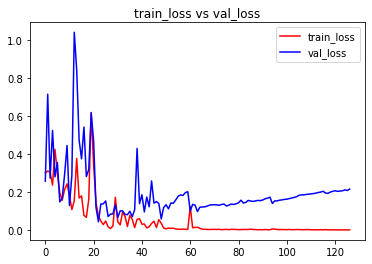

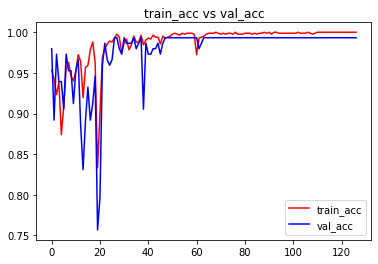

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

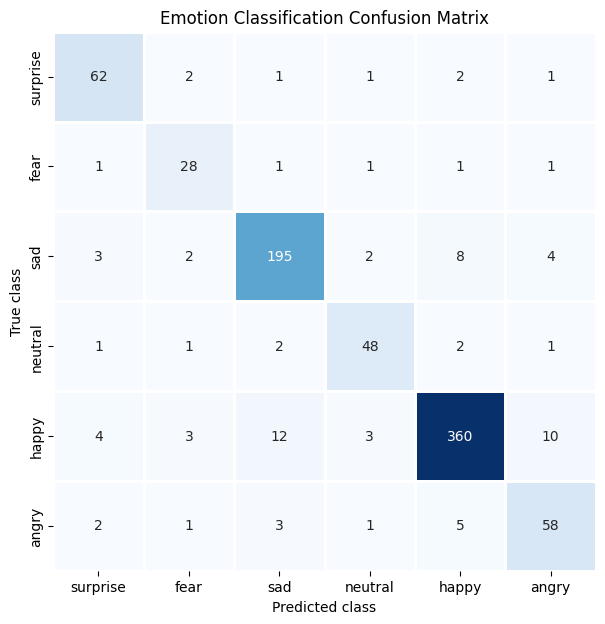

Total images: 833

Label distribution:
  surprise: 69 images (8.28%)
  fear: 33 images (3.96%)
  sad: 214 images (25.69%)
  neutral: 55 images (6.60%)
  happy: 392 images (47.06%)
  angry: 70 images (8.40%)


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
results = model.predict(X_test)
predicted_classes = np.argmax(results, axis=1)
y_true = np.argmax(y_test, axis=1)
label = ['sad', 'happy', 'disgust', 'angry', 'neutral', 'fear', 'surprise']
labels = {0: 'sad', 1: 'happy', 3: 'angry', 4: 'neutral', 5: 'fear', 6: 'surprise'}
cm = confusion_matrix(y_true, predicted_classes)
cm_df = pd.DataFrame(cm, index=label, columns=label)
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', cbar=False, linewidth=2, fmt='d')
plt.title('Emotion Classification Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have 'y_true' (true labels) and 'predicted_classes' (predicted labels)
# 'target_names' is a list of class names in the same order as your labels
target_names = ['sad', 'happy', 'angry', 'neutral', 'fear', 'surprise']

# Generate the classification report
report = classification_report(y_true, predicted_classes, target_names=target_names)

# Print the classification report
print(report)


              precision    recall  f1-score   support

    surprise       0.85      0.90      0.87        69
        fear       0.76      0.85      0.80        33
         sad       0.91      0.91      0.91       214
     neutral       0.86      0.87      0.86        55
       happy       0.95      0.92      0.94       392
       angry       0.77      0.83      0.80        70

    accuracy                           0.90       833
   macro avg       0.85      0.88      0.86       833
weighted avg       0.90      0.90      0.90       833



In [ ]:
print("Accuracy:", train_acc)

Accuracy: 90.88%
